In [1]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

path = "plots"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

In [2]:
from aimy_target_shooting.custom_types import TrajectoryCollection
from aimy_target_shooting import (
    export_tools,
    hitpoint_detection,
    hitpoint_utils,
)

In [3]:
import json
from aimy_target_shooting.configuration import get_config_path

path = get_config_path("hitpoint")
with open(path, "r") as file:
    config = json.load(file)

In [4]:
import seaborn as sns

text_color = "#222222"
sns.set(
    font="Arial",
    rc={
        "axes.axisbelow": True,
        "axes.edgecolor": "grey",
        "axes.facecolor": "whitesmoke",
        "axes.grid": False,
        "axes.labelcolor": text_color,
        "axes.spines.right": True,
        "axes.spines.top": True,
        "axes.titlecolor": "black",
        "grid.color": "white",
        "figure.constrained_layout.use": True,
        "figure.facecolor": "None",
        "figure.titlesize": 16,
        "figure.titleweight": "bold",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": text_color,
        "xtick.bottom": True,
        "xtick.color": text_color,
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": text_color,
        # "ytick.direction": "out",
        "ytick.left": True,
        "ytick.right": False,
        "savefig.dpi": 300,
    },
)

sns.set_context(
    "paper",
    rc={"font.size": 12, "axes.titlesize": 14, "axes.labelsize": 12},
)

### Loading Training Data

In [5]:
# Import location
directory_path = pathlib.Path(
    "/home/adittrich/Nextcloud/82_Data_Processed/MN5008_training_data"
)
file_name = "MN5008_grid_data_all.hdf5"

# Import trajectories
data_raw = export_tools.import_all_from_hdf5(file_path=directory_path / file_name)
print(f"Length raw: {len(data_raw)}")

Length raw: 3250


## Visualisation

#### Extract Hitpoints

In [6]:
detector = hitpoint_detection.HitPointDetection(config=config)
data_hitpoints = detector.evaluate_hitpoints(data_raw)
data_hitpoints = hitpoint_utils.remove_further_hitpoints(
    data_hitpoints, max_hitpoints=1
)
detection = hitpoint_detection.HitPointDetection(config=config)

#### Visualize Hitpoints in Plane

In [7]:
def add_table_2d(ax: plt.axes, shift: float = 0.0):
    table = plt.Rectangle(
        (0 + shift, -1.525 / 2),
        2.74,
        1.525,
        facecolor="dimgray",
        alpha=0.45,
        zorder=1,
        label="_nolegend_",
    )

    table_frame = plt.Rectangle(
        (0 + shift, -1.525 / 2),
        2.74,
        1.525,
        linewidth=8,
        facecolor="none",
        edgecolor="white",
        zorder=1,
        label="_nolegend_",
    )

    ax.add_patch(table)
    ax.add_patch(table_frame)

    ax.hlines(0.0, 0.0 + shift, 2.74 + shift, linewidth=3, color="white", zorder=1)
    ax.vlines(
        2.74 / 2 + shift,
        -1.525 / 2,
        1.525 / 2,
        linewidth=6,
        color="dimgrey",
        zorder=1,
        label="_nolegend_",
    )

In [8]:
def add_hitpoints_plot(
    trajectory_collection: TrajectoryCollection,
    ax: plt.axes,
    color_iterator=None,
    vertical: bool = False,
):
    hitpoint_axis = trajectory_collection.get_item(0)["axis"]

    axis = [0, 1, 2]
    axis.remove(hitpoint_axis)

    if color_iterator is not None:
        color = next(color_iterator)
    else:
        color = None

    x = []
    y = []

    for sample in trajectory_collection:
        hitpoints = np.array(sample["hitpoints"])

        if hitpoints.size == 0:
            continue

        x.append(hitpoints[:, axis[0]])
        y.append(hitpoints[:, axis[1]])

    if not vertical:
        ax.scatter(x, y, color=color, alpha=0.8, edgecolor=None)
    else:
        ax.scatter(y, x, color=color, alpha=0.8, edgecolor=None)

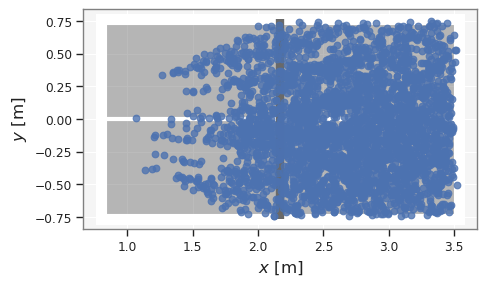

In [9]:
fig, ax = plt.subplots(figsize=(12.135, 12.135))
fig.align_labels()
fig.set_size_inches(5.00, 2.75)

ax.set_aspect("equal")
ax.grid()

add_table_2d(ax, 0.8)
add_hitpoints_plot(data_hitpoints, ax)

ax.set_xlabel("$x$ [m]")
ax.set_ylabel("$y$ [m]")

fig.savefig("plots/dataset_hitpoints.pdf")

#### Visualize 2D Histogram

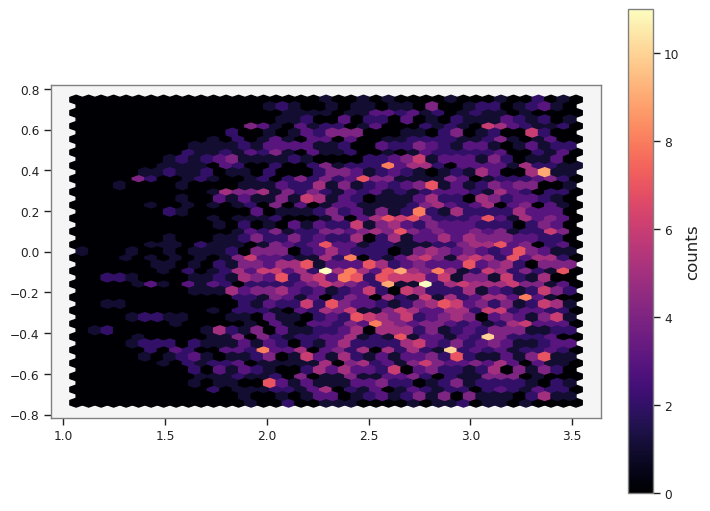

In [10]:
fig, ax = plt.subplots(figsize=(7.0, 5.0))

ax.set_aspect("equal")

hitpoint_axis = data_hitpoints.get_item(0)["axis"]

axis = [0, 1, 2]
axis.remove(hitpoint_axis)
gridsize = 40

x = []
y = []

for sample in data_hitpoints:
    hitpoints = np.array(sample.hitpoints)

    if hitpoints.size == 0:
        continue

    x.append(hitpoints[:, axis[0]])
    y.append(hitpoints[:, axis[1]])

x = np.array(x)
y = np.array(y)

hb = ax.hexbin(x, y, gridsize=gridsize, cmap="magma")

fig.colorbar(hb, ax=ax, label="counts")
fig.savefig("plots/dataset_histogram.pdf")

## Plot equidistant sampling

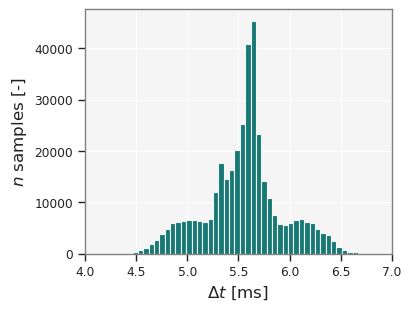

In [11]:
distances = []

for trajectory_data in data_raw:
    time_stamps = trajectory_data.time_stamps

    diff = np.diff(time_stamps)
    diff = list(diff)

    distances.extend(diff)

distances = [dist * 1000 for dist in distances]
fig, ax = plt.subplots(figsize=(4.0, 3.0))

n, bins, patches = ax.hist(distances, 1800, facecolor="#006c66", alpha=0.9)
ax.set_xlim(4, 7)

ax.set_xlabel(r"$\Delta t$ [ms]")
ax.set_ylabel(r"$n$ samples [-]")

ax.grid()

fig.savefig("plots/diff_histogram.pdf")
tikzplotlib.save("plots/diff_histogram.tex")